In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm,trange
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
frame_width = 1920
frame_height = 1080

# Import .csv data

In [6]:
data_frame = pd.read_csv(".\\data\\01_normalize_skeleton_data.csv")

# Preprocess
เราอยากจะใช้ features ที่ได้จาก YOLOv7 ในแต่ละ frame 
- ตำแหน่งข้อต่อของคน (keypoints)
- มุมที่แขนงอข้อศอกทางซ้ายและขวา (LE_angle,RE_angle)
- บริเวณทื่คนอยู่ (Xmin,Xmax,Ymin,Ymax)
- ท่าทางก่อนหน้า (axtion)

โดยที่เราจะสร้าง dataframe ขึ้นมาเรียงใหม่ข้อมูลเหล่านี้ใหม่ให้พร้อมกับการนำข้อมูลไป train โมเดล LSTM เพื่อทำนายท่าทางถัดไป เนื่องจากตอนนี้เป้าหมายของเราคือทำนายให้ได้ว่าต่อไปคนจะทำท่าทางอะไร จากค่าของ features ทั้งหมดใน frame ก่อนหน้า ดังนั้น 

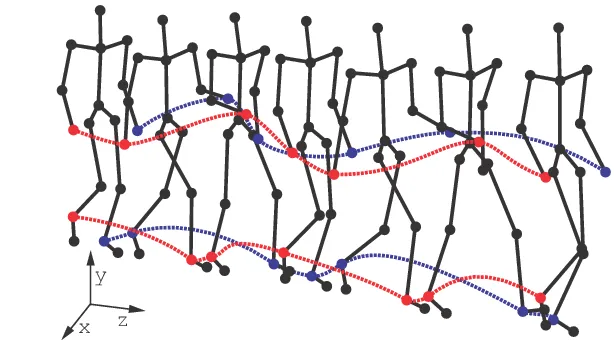

In [7]:
from PIL import Image
Image.open("..\\pic\\LSTM_skeleton_idea.webp")

In [8]:
def turn2list(input_string):
    # Input string
    input_string = str(input_string)
    # Use regular expression to extract numbers
    input_string = input_string.split('[')[-1]
    input_string = input_string.split(']')[0]
    numbers = input_string.split(' ')
    # print(numbers)
    number_list = []
    for num in numbers:
        if num!='':
            if num.split("\d")!=0:
                num = num.split("\d")[0]
            number_list.append(float(num))
    # Convert strings to float and create a list
    return number_list

def build_df_features(data_frame):
    total = len(data_frame)
    df_dict = {}
    df_times_collector = []
    df_features_collector = []
    df_actions_collector = []
    for i in tqdm(range(total)):
        df_features_collector.append(turn2list(data_frame.iloc[i]['features']))
        df_actions_collector.append(data_frame.iloc[i]['action'])
        df_times_collector.append(data_frame.iloc[i]['times'])
    
    df_dict["times"] = df_times_collector
    df_dict["features"] = df_features_collector
    df_dict["action"] = df_actions_collector

    new_dataframe = pd.DataFrame(df_dict)
    return new_dataframe

def append_step_features(data_frame,steps):
    total = len(data_frame)-steps
    df_dict = {}
    df_times_collector = []
    df_features_collector = []
    df_actions_collector = []
    for i in tqdm(range(total)):
        ds = []
        start_time = i
        for j in range(steps):
            ds.append(np.array(turn2list(data_frame.iloc[i+j]['features']),dtype=np.float32))
        ds = np.stack(ds,axis=0)
        stop_time = i+j

        df_features_collector.append(ds)
        df_actions_collector.append(data_frame.iloc[i+steps]['action'])
        df_times_collector.append([start_time,stop_time])
    
    df_dict["times"] = df_times_collector
    df_dict["features"] = df_features_collector
    df_dict["action"] = df_actions_collector

    new_dataframe = pd.DataFrame(df_dict)
    # new_dataframe.to_csv(f"features_steps_{steps}_.csv",index=False)
    return new_dataframe

# Create Dataset using pd.Dataframe

In [9]:
steps=5 # how many frames used for collecting features
new_data_frame = append_step_features(data_frame,steps)

  0%|          | 0/1256 [00:00<?, ?it/s]

100%|██████████| 1256/1256 [00:00<00:00, 1436.57it/s]


In [11]:
original_data_frame = new_data_frame.copy()
original_data_frame.head()

,times,features,action
0,"[0, 4]","[[0.43203124, 0.32222223, 0.44010416, 0.310648...",stand
1,"[1, 5]","[[0.43229166, 0.32175925, 0.44036457, 0.310185...",stand
2,"[2, 6]","[[0.43203124, 0.3210648, 0.44036457, 0.3097222...",stand
3,"[3, 7]","[[0.43229166, 0.3210648, 0.44036457, 0.3097222...",stand
4,"[4, 8]","[[0.43229166, 0.32083333, 0.440625, 0.30949074...",stand


# Load features and Label

In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# {'clap':0, 'raise your left':1, 'raise your right':2, 'stand':3, 'walk':4}
X = new_data_frame['features']
new_data_frame['action'] = pd.Categorical(new_data_frame.action)
print(new_data_frame.action)
new_data_frame['action'] = new_data_frame.action.cat.codes
# Turn response variable into one-hot response vectory = to_categorical(df.response)
y = to_categorical(new_data_frame.action)


0       stand
1       stand
2       stand
3       stand
4       stand
        ...  
1251    stand
1252    stand
1253    stand
1254    stand
1255    stand
Name: action, Length: 1256, dtype: category
Categories (5, object): ['clap', 'raise your left', 'raise your right', 'stand', 'walk']


In [13]:
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(
  X,y , random_state=104,test_size=0.25, shuffle=True)

In [14]:
train_X = X_train.values
test_X = X_test.values
train_y = y_train
test_y = y_test
# reshape input to be 3D [samples, timesteps, features]
train_X = np.stack(list(train_X),axis=0)
test_X = np.stack(list(test_X),axis=0)

In [15]:
print(train_X.shape)
print(test_X.shape)

(942, 5, 40)
(314, 5, 40)


# Create model and train!

In [16]:
# design network
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = Sequential([
    LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2])),
    layers.Dropout(0.3),
    # layers.Dense(16, activation='relu'),
    # layers.BatchNormalization(),
    # layers.Dropout(0.3),
    layers.Dense(5, activation='softmax'),
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

checkpoint_path = f"00_training_normalize_steps_{steps}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=True,callbacks=[early_stopping,cp_callback])
# history = model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=True,callbacks=[cp_callback])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                3648      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 5)                 85        
                                                                 
Total params: 3,733
Trainable params: 3,733
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100

Epoch 00001: saving model to 00_training_normalize_steps_5\cp.ckpt
59/59 - 3s - loss: 1.5456 - acc: 0.3259 - val_loss: 1.3718 - val_acc: 0.5414 - 3s/epoch - 53ms/step
Epoch 2/100

Epoch 00002: saving model to 00_training_normalize_steps_5\cp.ckpt
59/59 - 0s - loss: 1.3139 - acc: 0.5223 - val_loss: 1

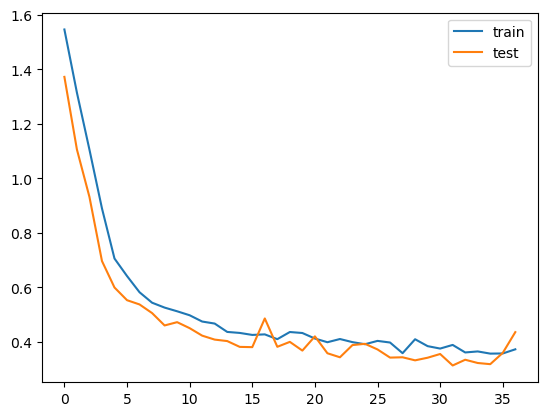

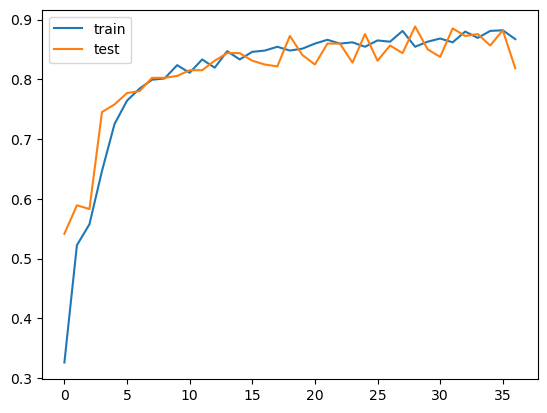

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [18]:
model.load_weights(checkpoint_path)

# To save whole model and easy to use

In [102]:
model.save(f'saved_model_steps_{steps}/model')

INFO:tensorflow:Assets written to: saved_model_steps_3/model\assets


INFO:tensorflow:Assets written to: saved_model_steps_3/model\assets


# Visualize some testing on action recognition

In [86]:
np.argmax(model.predict(test_X),axis=1)

array([3, 4, 4, 4, 4, 4, 3, 1, 0, 4, 1, 4, 4, 0, 3, 0, 3, 3, 0, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 3, 3, 3, 4, 2, 3, 3, 3, 3, 3, 0, 3, 4, 1, 4, 4,
       3, 4, 1, 4, 3, 4, 0, 4, 3, 4, 3, 0, 1, 0, 3, 2, 2, 4, 3, 0, 3, 0,
       3, 4, 0, 3, 0, 3, 0, 3, 4, 0, 2, 1, 4, 0, 0, 1, 3, 3, 0, 3, 2, 0,
       3, 2, 3, 3, 4, 4, 4, 2, 3, 3, 4, 0, 0, 2, 0, 0, 2, 2, 3, 3, 1, 3,
       0, 1, 2, 3, 0, 1, 3, 3, 1, 4, 3, 4, 2, 2, 3, 3, 0, 0, 4, 1, 4, 3,
       0, 0, 2, 3, 0, 0, 3, 3, 4, 3, 2, 0, 3, 4, 3, 3, 2, 4, 3, 4, 3, 4,
       3, 3, 3, 2, 4, 3, 0, 3, 3, 1, 1, 0, 3, 0, 4, 4, 4, 4, 3, 2, 4, 3,
       0, 3, 3, 0, 4, 3, 0, 4, 3, 1, 0, 3, 4, 3, 3, 1, 4, 4, 3, 2, 3, 3,
       0, 3, 4, 4, 0, 1, 1, 1, 1, 3, 3, 4, 0, 2, 3, 3, 0, 0, 0, 4, 1, 4,
       4, 1, 4, 1, 4, 0, 2, 0, 0, 4, 4, 0, 4, 0, 3, 0, 3, 4, 0, 3, 3, 4,
       4, 0, 3, 3, 4, 3, 0, 4, 3, 0, 3, 4, 2, 0, 3, 3, 3, 0, 2, 0, 3, 0,
       4, 2, 4, 4, 4, 0, 2, 4, 0, 0, 3, 3, 4, 2, 0, 4, 0, 0, 3, 1, 2, 0,
       3, 0, 1, 1, 0, 3, 0, 3, 3, 2, 3, 1, 2, 0, 2,